# Описание проекта
**Цель:** помочь маркетологам оптимизировать маркетинговые затраты.

Предоставлены данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

<details>
<summary> Описание данных </summary>

_Таблица visits (лог сервера с информацией о посещениях сайта):_

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

_Таблица orders (информация о заказах):_
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

_Таблица costs (информация о затратах на маркетинг):_
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день
</details>

**Инструкция по выполнению проекта:**

[1. Загрузка данных и подготовка их к анализу](#id-section1)

[2. Построение отчётов и расчет метрик](#id-section2)

    2.1. Продукт

        - Сколько людей пользуются в день, неделю, месяц?
        - Сколько сессий в день?
        - Сколько длится одна сессия?
        - Как часто люди возвращаются?

    2.2. Продажи

        - Когда люди начинают покупать?
        - Сколько раз покупают за период?
        - Какой средний чек?
        - Сколько денег приносят? (LTV)

    2.3. Маркетинг

        - Сколько денег потратили? Всего / на каждый источник / по времени
        - Сколько стоило привлечение одного покупателя из каждого источника?
        - На сколько окупились расходы? (ROI)

[3. Вывод](#id-section3)

<div id='id-section1'/>

## 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Все ячейки заполнены. Приведем названия столбцов к нижнему регистру и избавимся  от пробелов. В столбцах Start Ts и End Ts изменим тип данных.

In [5]:
visits.columns = visits.columns.str.lower()

In [6]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [7]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [8]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Проделаем действия аналогично таблице visits

In [10]:
orders.columns = orders.columns.str.lower()

In [11]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [12]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [13]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [15]:
costs['dt'] = pd.to_datetime(costs['dt'])

Во всех таблицах привели название столбцов к единому виду, заменили тип данных в столбцах с датой.

<div id='id-section2'/>

## 2. Построение отчётов и расчет метрик

### 2.1. Продукт

In [16]:
#посчитаем продолжительность сессии
visits['continue_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [17]:
visits['continue_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: continue_sec, dtype: float64

In [18]:
#есть большие выбросы,посмотрим продолжительность сессии у большинства пользователей 
visits['continue_sec'].mode()

0    60
dtype: int64

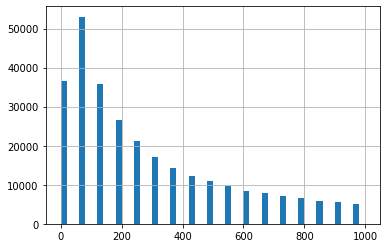

In [19]:
#посмотрим на распределение большей части сессий
visits['continue_sec'].hist(bins=50, range=(0, 1000))

In [20]:
#посмотрим, как отличается продолжительность в зависимости от устройства
visits.groupby('device').agg({'continue_sec': ['mean','median', 'count']})

continue_sec               
                mean median   count
device                             
desktop   703.946977    360  262567
touch     479.619407    180   96833

In [21]:
#посчитаем количество визитов с нулевой продолжительностью
visits[visits['continue_sec'] == 0]['continue_sec'].count()

35794

In [22]:
#проверим, возможно, нулевые сессии есть только на определенном устройстве
visits[visits['continue_sec'] == 0].groupby('device').agg({'uid': ['count']})

,uid
,count
device,
desktop,23689
touch,12105


Вывод: половина пользователей пользуются сервисом до 5 минут, продолжительность сессии большей части из них составляет 1 минуту. При этом на сенсорных устройствах продолжительность сессии короче, чем на десктопных.  
Продолжительность сессии на сенсорных устройствах у 50% пользователей - 3 минуты.  
Продолжительность сессии на десктопных устройствах у 50% пользователей - 6 минут.

Пользователей, просматривающих сайт с десктопных устройств, в 2.7 раза больше, чем с сенсорных.

Есть еще визиты с нулевой продолжительность. Можно предположить, что на стороне пользователя возникли технические сложности, например, с Интернетом. Но такие визиты составляют 10% от общего числа. Это довольно много.  
Визиты с нулевой продолжительность не зависят от типа устройства. Интересно было бы понять причины. Возможно, не работает сайт на определенных системах. Для выяснения требуется дополнительный анализ.

In [23]:
#создадим столбцы с годом, месяцем, неделей и днем пользования сайтом
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year

In [24]:
visits.head()

,device,end_ts,source_id,start_ts,uid,continue_sec,date,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,52,12,2017


In [25]:
#посчитаем количество пользователей и количество сессий в день
user_date = visits.groupby('date').agg({'uid': ['count','nunique']})

In [26]:
user_date = user_date.reset_index()

In [27]:
user_date.columns = ['date', 'date_session', 'date_user']

In [28]:
user_date

,date,date_session,date_user
0,2017-06-01,664,605
1,2017-06-02,658,608
2,2017-06-03,477,445
3,2017-06-04,510,476
4,2017-06-05,893,820
...,...,...,...
359,2018-05-27,672,620
360,2018-05-28,1156,1039
361,2018-05-29,1035,948
362,2018-05-30,1410,1289


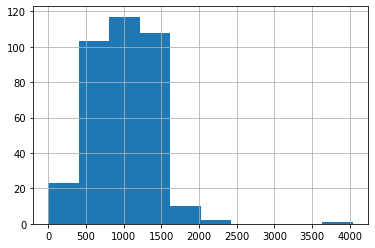

In [29]:
user_date['date_session'].hist()

In [30]:
user_date['date_session_per_user'] = user_date['date_session']/ user_date['date_user']

In [31]:
user_date.mean()

date_session             987.362637
date_user                907.991758
date_session_per_user      1.082170
dtype: float64

In [32]:
#посчитаем количество пользователей и количество сессий в день
user_week = visits.groupby(['year', 'week']).agg({'uid': ['count','nunique']})

In [33]:
user_week.columns=['week_session', 'week_user']

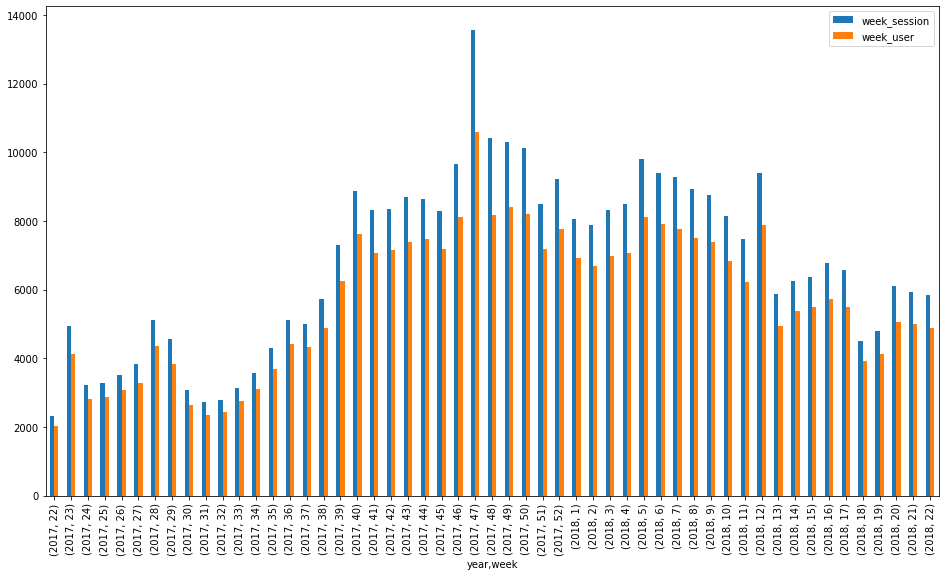

In [34]:
user_week.plot(kind='bar', figsize=(16,9))

In [35]:
user_week['week_session_per_user'] = user_week['week_session']/ user_week['week_user']

In [36]:
user_week.mean()

week_session             6781.132075
week_user                5716.245283
week_session_per_user       1.179025
dtype: float64

In [37]:
user_month = visits.groupby(['year', 'month']).agg({'uid': ['count','nunique']})

In [38]:
user_month.columns=['month_session', 'month_user']

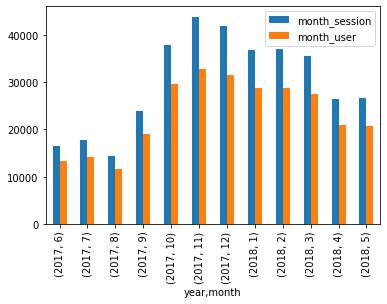

In [39]:
user_month.plot(kind='bar')

In [40]:
user_month['month_session_per_user'] = user_month['month_session']/ user_month['month_user']

In [41]:
user_month.mean()

month_session             29950.000000
month_user                23228.416667
month_session_per_user        1.280889
dtype: float64

In [42]:
visits['uid'].count() / visits['uid'].nunique()

1.5751482453795214

Вывод: В основном в день сайтом пользуются от 500 до 1500 человек. Среднее значение: 900. Число сессий незначительно больше. То есть на 1 человека приходится 1 сессия в день.
В неделю в среднем пользуются 5700 человек. Число сессий на 1000 больше.  
Средняя посещяемость сайта в месяц - 23тыс уникальных пользователей. Среднее число сессий в месяц - 30 тыс. Большинство посетителей не заходят на сайт чаще 1 раз в  месяц. Количество сессий на одного человека  в месяц: 1.28.
С октября по март наблюдается рост числа пользователей, максимальное количество пользователей наблюдалось в ноябре. С апреля начинается спад. Возможно, в это время продвиение было более активно, а может быть играет роль сезонность, и зимой люди чаще пользуются сервисом.
Отношение числа сессий к числу уникальных пользователей за весь год составляет 1.5. Это значит, что как минимум половина пользователей пользовались сайтом только 1 раз за весь год.

In [43]:
#По каждому пользователю выделим дату совершения первого события и добавим её к датафрейму
min_visit_datetime = visits.groupby(['uid'])['start_ts'].min()
min_visit_datetime.name = 'min_visit_datetime'
visits = visits.join(min_visit_datetime,on='uid')


In [44]:
#выделим месячные когорты и посчитаем lifetime 
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['min_visit_datetime'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)


In [45]:
visits

,device,end_ts,source_id,start_ts,uid,continue_sec,date,week,month,year,min_visit_datetime,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,51,12,2017,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,8,2,2018,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,26,7,2017,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,20,5,2018,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,52,12,2017,2017-12-27 14:06:00,2017-12-01,2017-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,19,2017-07-29,30,7,2017,2017-07-29 19:07:00,2017-07-01,2017-07-01,0
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,19,2018-01-25,4,1,2018,2018-01-25 17:38:00,2018-01-01,2018-01-01,0
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,19,2018-03-03,9,3,2018,2018-03-03 10:12:00,2018-03-01,2018-03-01,0
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,19,2017-11-02,44,11,2017,2017-11-02 10:12:00,2017-11-01,2017-11-01,0


In [46]:
def RetentionRate(df):
    #Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый месяц жизни
    cohorts = df.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

    #Найдём исходное количество пользователей в когорте. 
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

    #Объединим данные по когортам с исходным количеством пользователей в когорте
    cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

    #рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    print(cohorts.groupby('cohort_lifetime')['retention'].mean())
    cohorts.groupby(['cohort_lifetime'])['retention'].mean().plot.bar(ylim=(0, 0.1))
    #Построим сводную таблицу и создадим тепловую карту
    retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
    sns.set(style='white')
    plt.figure(figsize=(12, 8))
    plt.title('Cohorts: User Retention')
    sns.heatmap(retention_pivot, annot=True, vmin=0, vmax=0.1, center=0.05, fmt='.1%', linewidths=1, linecolor='gray', cmap= 'coolwarm')

cohort_lifetime
0     1.000000
1     0.065167
2     0.046333
3     0.042760
4     0.040595
5     0.039444
6     0.036957
7     0.037509
8     0.035465
9     0.035159
10    0.034062
11    0.044951
Name: retention, dtype: float64


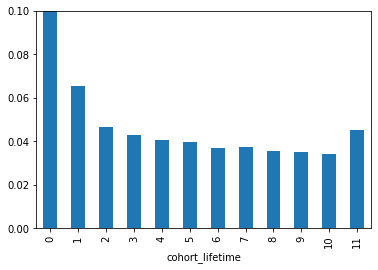

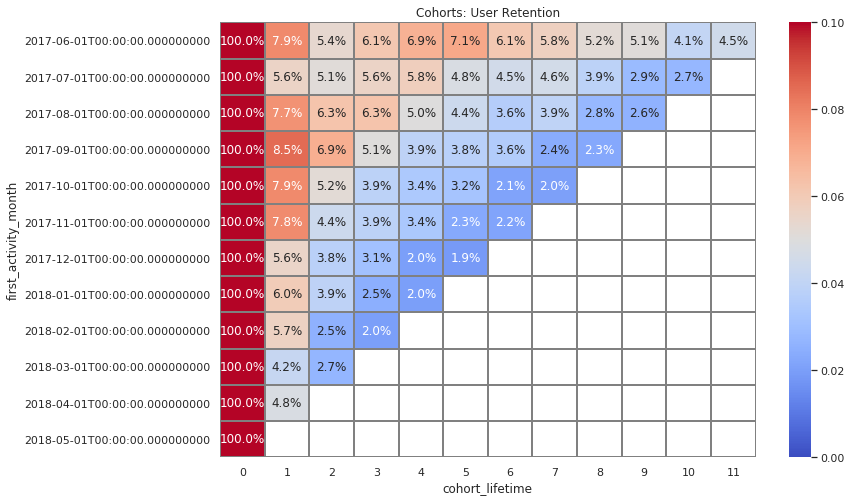

In [47]:
RetentionRate(visits)

cohort_lifetime
0     1.000000
1     0.062032
2     0.042356
3     0.038487
4     0.036166
5     0.033899
6     0.033160
7     0.032018
8     0.029721
9     0.029079
10    0.030923
11    0.042681
Name: retention, dtype: float64


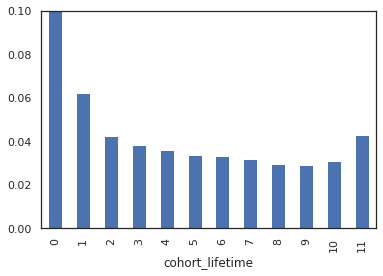

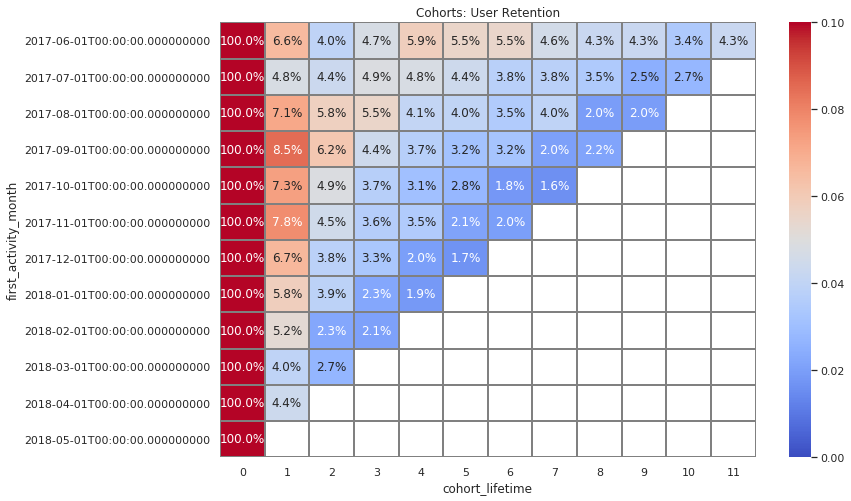

In [48]:
#посчитаем RR для разных устройств
RetentionRate(visits[visits['device'] == 'touch'])

cohort_lifetime
0     1.000000
1     0.068029
2     0.048974
3     0.045578
4     0.043577
5     0.043175
6     0.039740
7     0.040531
8     0.039005
9     0.038950
10    0.036819
11    0.048253
Name: retention, dtype: float64


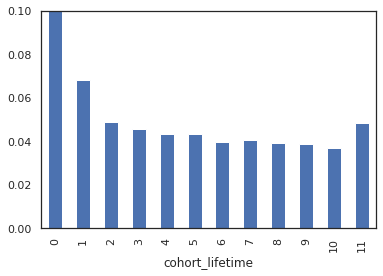

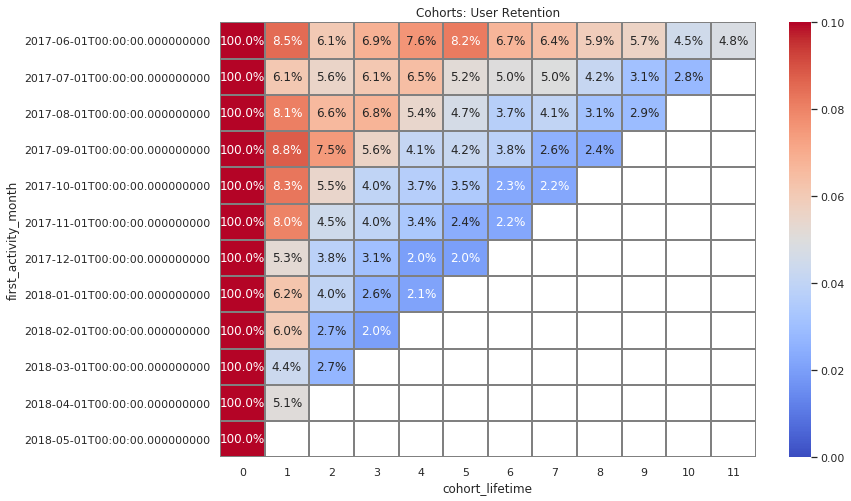

In [49]:
RetentionRate(visits[visits['device'] == 'desktop'])

In [50]:
source = pd.Series(visits['source_id'].unique())

In [51]:
source = source.sort_values()

In [52]:
#напишем аналогичную фунцию для RR, но без тепловой карты
def RetentionRateLight(df):
    #Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый месяц жизни
    cohorts = df.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

    #Найдём исходное количество пользователей в когорте. 
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

    #Объединим данные по когортам с исходным количеством пользователей в когорте
    cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

    #рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    print(cohorts.groupby('cohort_lifetime')['retention'].mean())

In [53]:
#найдем RR для источников
for i in source:
    print('Источник №', i)
    RetentionRateLight(visits[visits['source_id'] == i])

Источник № 1
cohort_lifetime
0     1.000000
1     0.145781
2     0.086122
3     0.080129
4     0.079448
5     0.078507
6     0.071245
7     0.077776
8     0.066042
9     0.076812
10    0.075238
11    0.113169
Name: retention, dtype: float64
Источник № 2
cohort_lifetime
0     1.000000
1     0.167883
2     0.112146
3     0.102906
4     0.096199
5     0.090376
6     0.090454
7     0.087643
8     0.085947
9     0.089682
10    0.086252
11    0.117493
Name: retention, dtype: float64
Источник № 3
cohort_lifetime
0     1.000000
1     0.046681
2     0.035708
3     0.037301
4     0.035562
5     0.034134
6     0.032727
7     0.032722
8     0.032303
9     0.030946
10    0.032525
11    0.039044
Name: retention, dtype: float64
Источник № 4
cohort_lifetime
0     1.000000
1     0.068012
2     0.050786
3     0.047840
4     0.046438
5     0.048543
6     0.044837
7     0.044297
8     0.043968
9     0.040726
10    0.039501
11    0.052530
Name: retention, dtype: float64
Источник № 5
cohort_lifetime
0     1

Для источников 1, 2 и 9 показатели  заметно выше. Посмотрим на тепловые карты этих источников

cohort_lifetime
0     1.000000
1     0.145781
2     0.086122
3     0.080129
4     0.079448
5     0.078507
6     0.071245
7     0.077776
8     0.066042
9     0.076812
10    0.075238
11    0.113169
Name: retention, dtype: float64


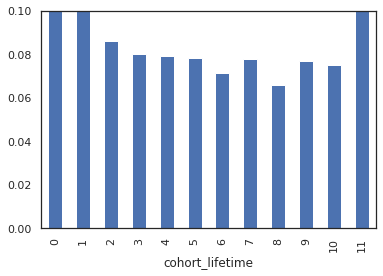

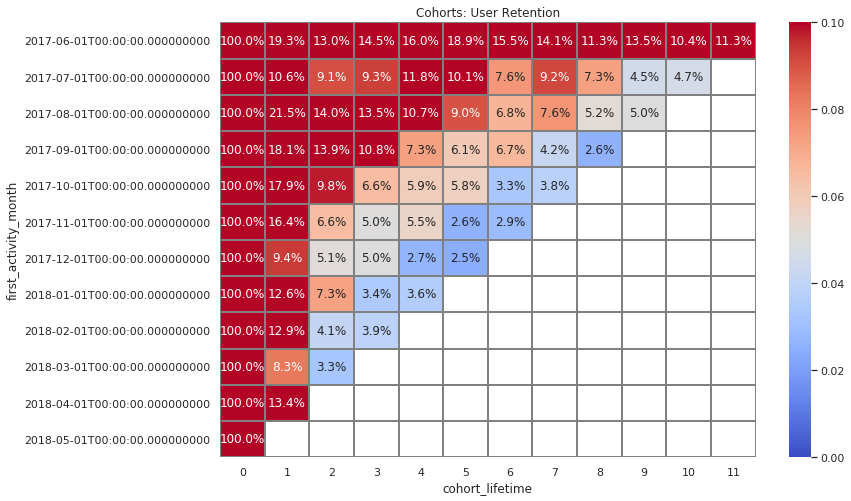

In [54]:
RetentionRate(visits[visits['source_id'] == 1])

cohort_lifetime
0     1.000000
1     0.167883
2     0.112146
3     0.102906
4     0.096199
5     0.090376
6     0.090454
7     0.087643
8     0.085947
9     0.089682
10    0.086252
11    0.117493
Name: retention, dtype: float64


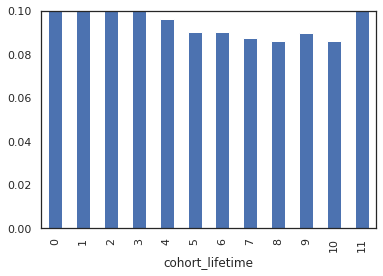

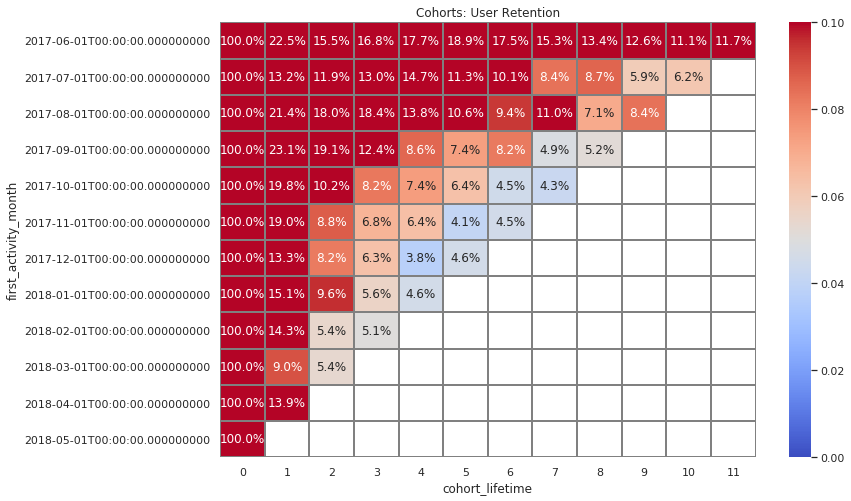

In [55]:
RetentionRate(visits[visits['source_id'] == 2])

cohort_lifetime
0     1.000000
1     0.173009
2     0.150068
3     0.118146
4     0.114618
5     0.104645
6     0.089537
7     0.090263
8     0.088845
9     0.080882
10    0.058739
11    0.055777
Name: retention, dtype: float64


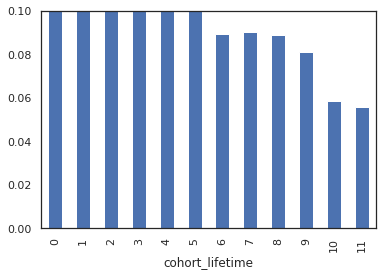

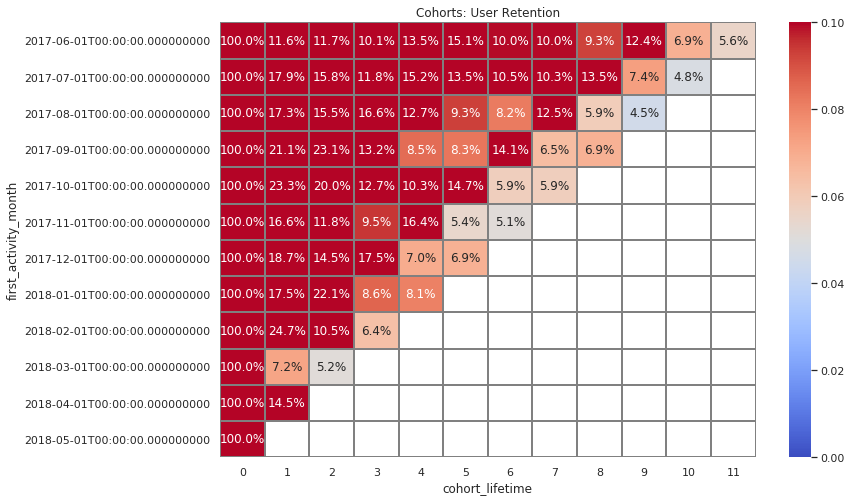

In [56]:
RetentionRate(visits[visits['source_id'] == 9])

Вывод: Коэффициент удержания низкий. Через месяц в среднем возвращается всего 6.5% пользователей. Это самый высокий retention rate за весь период. С каждым месяцем коэффициент падает. Наиболее высокие показатели у 1-ой когорты. Там даже в конце года RR=4%, в других когортах показатели ниже.
В апреле и мае RR очень низкий по всем когортам. И в большинстве когорт составляет 2%.  

Retention rate пользователей, использующих десктопные устройства , выше чем у пользователей, использующих сенсорные. Разница незначительная, в пределах 1-го процента.

По источникам же показатели значительно различаются. Самый высокий RR у источников 1, 2 и 9. Через месяц в среднем возвращается 14-17% пользователей. Показатели в последующих месяцах выше средних по всем когортам.

### 2.2. Продажи

In [57]:
#для начала посмотрим среднее время жизни пользователей, найдем разницу между последним и первым визитом
max_visit_datetime = visits.groupby(['uid'])['start_ts'].max()
max_visit_datetime.name = 'max_visit_datetime'
visits = visits.join(max_visit_datetime,on='uid')
visits['lifetime'] = (visits['max_visit_datetime'] - visits['min_visit_datetime'])/ np.timedelta64(1,'D')
visits['lifetime'] = visits['lifetime'].round().astype(int)



In [58]:
#создадим таблицу с уникальным uid и временем жизни, удалим дубли
lifetime = visits[['uid', 'lifetime']].drop_duplicates().reset_index(drop=True)

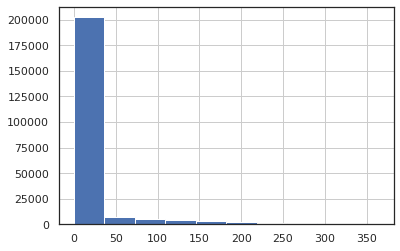

In [59]:
lifetime['lifetime'].hist()

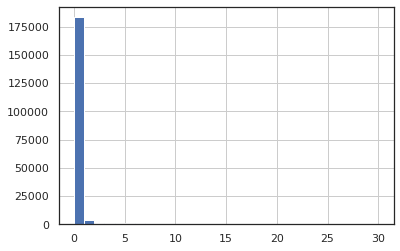

In [60]:
#посмотрим на первые 30 дней
lifetime['lifetime'].hist(bins=30, range=(0,30))

In [61]:
#большинство пользователей заходили в сервис только 1 раз. Найдем их количество
lifetime[lifetime['lifetime'] ==0]['lifetime'].count()

183257

In [62]:
lifetime[lifetime['lifetime'] !=0]['lifetime'].describe()

count    44912.000000
mean        82.125223
std         85.142278
min          1.000000
25%         11.000000
50%         52.000000
75%        131.000000
max        364.000000
Name: lifetime, dtype: float64

In [63]:
lifetime['lifetime'].count()

228169

In [64]:
lifetime[lifetime['lifetime'] <= 180]['lifetime'].count()

221513

80% пользователей имели только 1 сессию за год. Только 20% пользовались более 1 раза, при этом 75% из них имеют время жизни 4.5 месяца. 97% пользователей от общего числа либо не пользуются сервисом повторно, либо пользуются в течение полугода. Поэтому в дальнейшем будем рассматривать период в 6 месяцев. 

In [65]:
#создадим таблицу с уникальным uid, датай первого визита, device и id источника
min_visit=visits[visits['start_ts'] == visits['min_visit_datetime']][['uid','min_visit_datetime', 'source_id', 'device']]

In [66]:
min_visit

,uid,min_visit_datetime,source_id,device
0,16879256277535980062,2017-12-20 17:20:00,4,touch
1,104060357244891740,2018-02-19 16:53:00,2,desktop
2,7459035603376831527,2017-07-01 01:54:00,5,touch
4,9969694820036681168,2017-12-27 14:06:00,3,desktop
5,16007536194108375387,2017-09-03 21:35:00,5,desktop
...,...,...,...,...
359395,18363291481961487539,2017-07-29 19:07:00,2,desktop
359396,18370831553019119586,2018-01-25 17:38:00,1,touch
359397,18387297585500748294,2018-03-03 10:12:00,4,desktop
359398,18388616944624776485,2017-11-02 10:12:00,5,desktop


In [67]:
#объединим с таблицей покупок
purchases = orders.merge(min_visit, on='uid', how='left')

In [68]:
purchases

,buy_ts,revenue,uid,min_visit_datetime,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,3,desktop
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,4,touch
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,10,desktop
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,3,desktop
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,3,desktop


In [69]:
#По каждому пользователю выделим дату совершения первой покупки и добавим её к датафрейму
min_order_datetime = purchases.groupby(['uid'])['buy_ts'].min()
min_order_datetime.name = 'min_order_datetime'
purchases = purchases.join(min_order_datetime,on='uid')

In [70]:
#выясним, когда люди начинают покупать после первого визита
purchases['difference'] = (purchases['min_order_datetime'] - purchases['min_visit_datetime']) / np.timedelta64(1,'D')
purchases['difference'] = purchases['difference'].round().astype(int)

In [71]:
min_purchases = purchases[['uid', 'difference']]
min_purchases = min_purchases.drop_duplicates().reset_index(drop=True)

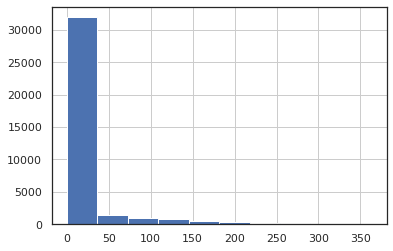

In [72]:
min_purchases['difference'].hist()

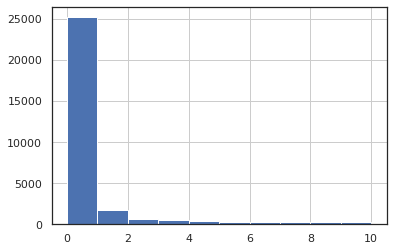

In [73]:
min_purchases['difference'].hist(bins=10, range=(0, 10))

В большинстве случаев разница между днем первого входа и днем покупки равна 0. Т.е. большинство пользователей делают покупки в тот же день. 

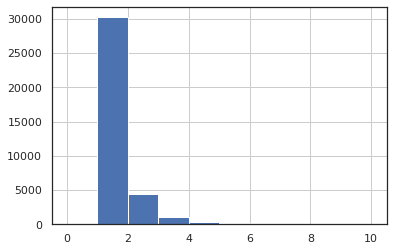

In [74]:
#посмотрим, сколько покупок совершает каждый пользователь
purchases.groupby('uid')['revenue'].count().hist(bins=10, range=(0,10))

In [75]:
purchases.groupby('uid')['revenue'].count().describe()

count    36523.000000
mean         1.380363
std          3.454461
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        239.000000
Name: revenue, dtype: float64

Чаще всего совершают 1 покупку.

In [76]:
#посмотрим, сколько составляет средний чек
purchases['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

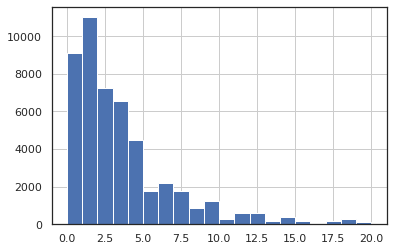

In [77]:
purchases['revenue'].hist(bins=20, range=(0,20))

In [78]:
len(purchases[purchases['revenue'] == 0])

51

Вывод: Как правило, пользователи покупают в день первого визита на сайт. Можно предположить, что сервис вызывает доверие. В течение года чаще всего люди покупали всего 1 раз.  
Средний чек равен 5.0. Обусловлено эта цифра выбросами. По медиане чек в два раза меньше и составляет 2.5.
Есть незначительное число покупок с суммой чека, равной 0. Возможно, это какие-то акции или подарки. 

In [79]:
#выделим месячные когорты
purchases['order_month'] = purchases['buy_ts'].astype('datetime64[M]')
purchases['first_order_month'] = purchases['min_order_datetime'].astype('datetime64[M]')
purchases['cohort_lifetime'] = purchases['order_month'] - purchases['first_order_month']
purchases['cohort_lifetime'] = purchases['cohort_lifetime'] / np.timedelta64(1,'M')
purchases['cohort_lifetime'] = purchases['cohort_lifetime'].round().astype(int)

In [80]:
#сделаем срез за полгода
purchases = purchases[purchases['cohort_lifetime'] <=6]

In [81]:
def Ltv(df):
    #Посчитаем количество новых покупателей (n_buyers) за каждый месяц:
    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']

    #Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
    cohorts = df.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
    #Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    #LTV считают из валовой прибыли. Значит, найдем валовую прибыль, умножив выручку на маржинальность. Маржинальность примем за 1. 
    margin_rate = 1
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')

    report['ltv'] = report['gp'] / report['n_buyers']
    output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
   
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Cohorts: LTV')
    sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.1f', linewidths=1, linecolor='gray', cmap= 'coolwarm');
    plt.show()

    #посмотрим накопительную сумму
    print(output.cumsum(axis=1).mean(axis=0))
    
    output.cumsum(axis=1).mean(axis=0).plot()
    
    return output.fillna('')
    

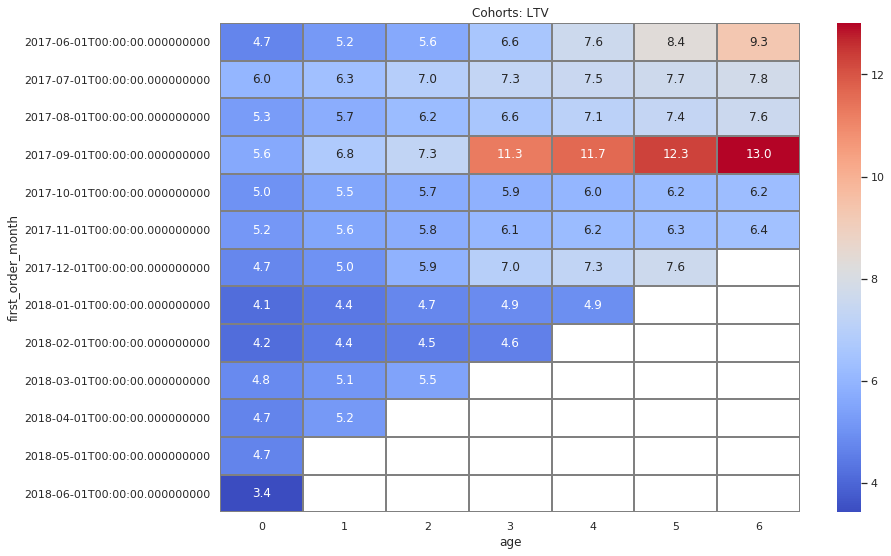

age
0    4.801682
1    5.395666
2    5.821811
3    6.689763
4    7.298634
5    7.969053
6    8.387686
dtype: float64


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,


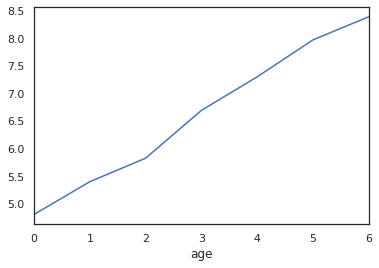

In [82]:
Ltv(purchases)

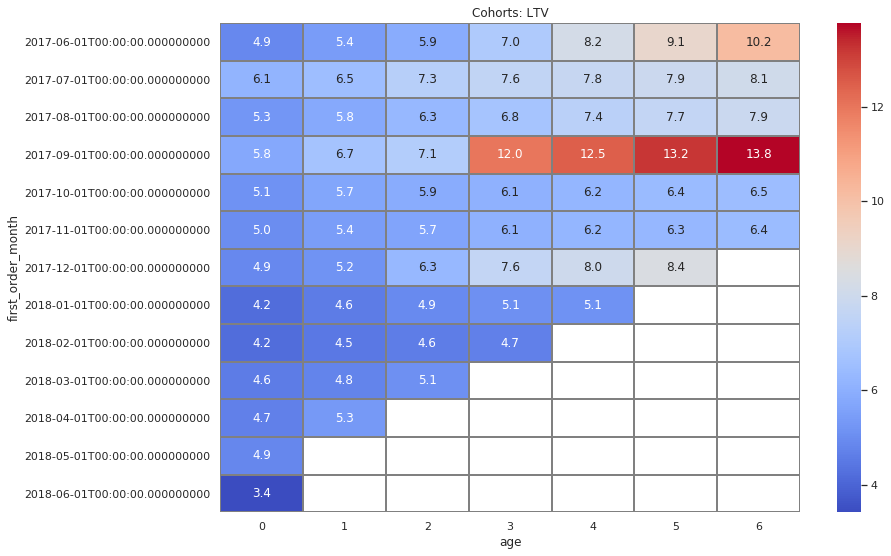

age
0    4.850218
1    5.445081
2    5.912557
3    6.990316
4    7.678679
5    8.425486
6    8.798811
dtype: float64


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.889172,0.518467,0.496298,1.11932,1.1709,0.866504,1.12203
2017-07-01,6.139817,0.366527,0.770852,0.323899,0.177418,0.160301,0.136507
2017-08-01,5.255449,0.55018,0.519919,0.447989,0.592496,0.290844,0.228025
2017-09-01,5.797504,0.926634,0.413992,4.85504,0.482424,0.764167,0.525386
2017-10-01,5.130374,0.559994,0.20818,0.180235,0.156087,0.140631,0.0988109
2017-11-01,4.996515,0.447435,0.230544,0.379035,0.162432,0.0598948,0.134639
2017-12-01,4.881767,0.282688,1.14158,1.3202,0.388722,0.415979,
2018-01-01,4.210019,0.343362,0.362221,0.162319,0.0714286,,
2018-02-01,4.188536,0.315447,0.0912789,0.090057,,,


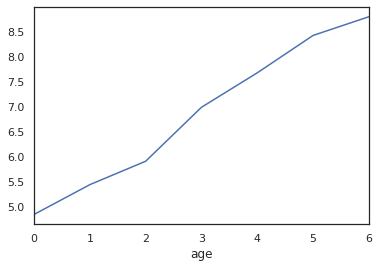

In [83]:
#посмотрим ltv относительно устройства
Ltv(purchases[purchases['device'] == 'desktop'])

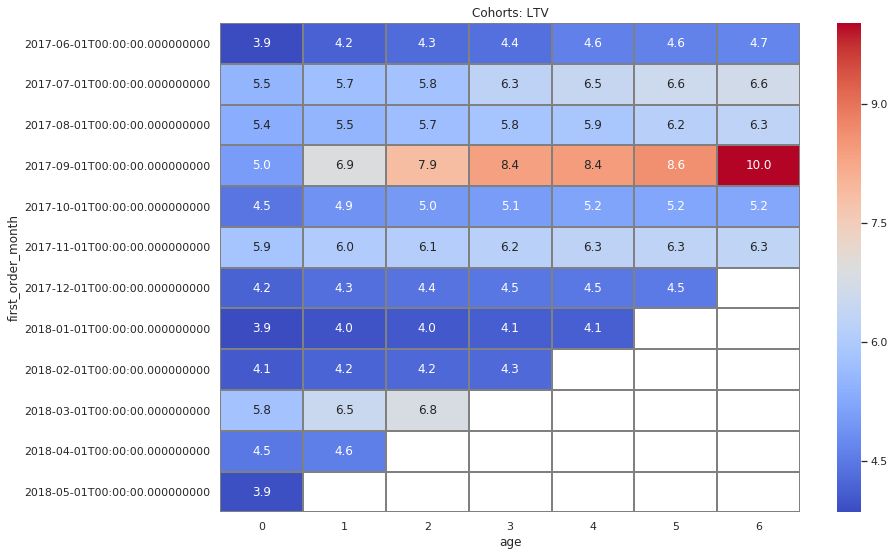

age
0    4.694024
1    5.165910
2    5.421007
3    5.437224
4    5.685489
5    6.007309
6    6.535856
dtype: float64


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,3.850841,0.309626,0.126604,0.0816511,0.235857,0.0409034,0.0406542
2017-07-01,5.512065,0.214836,0.0572544,0.493804,0.174383,0.139698,0.0575567
2017-08-01,5.368203,0.131758,0.191133,0.144492,0.0656641,0.251758,0.135117
2017-09-01,5.041130,1.87079,0.942739,0.507663,0.0776437,0.185172,1.3967
2017-10-01,4.450149,0.429839,0.11802,0.0562129,0.13177,0.0317574,0.0236386
2017-11-01,5.851457,0.186887,0.0630464,0.086702,0.0844901,0.0273775,0.0280927
2017-12-01,4.171501,0.172302,0.0706546,0.0590971,0.013781,0.0304515,
2018-01-01,3.851087,0.108827,0.0826323,0.0680258,0.029299,,
2018-02-01,4.052062,0.154645,0.0360664,0.0212204,,,


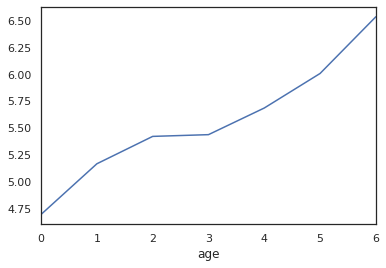

In [84]:
Ltv(purchases[purchases['device'] == 'touch'])

In [85]:
#создадим еще одну функцию, аналогичную предыдущей, но без графиков
def LtvLight(df):
    #Посчитаем количество новых покупателей (n_buyers) за каждый месяц:
    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']

    #Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
    cohorts = df.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
    #Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    #LTV считают из валовой прибыли. Значит, найдем валовую прибыль, умножив выручку на маржинальность. Маржинальность примем за 1. 
    margin_rate = 1
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')

    report['ltv'] = report['gp'] / report['n_buyers']
    output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    #посмотрим накопительную сумму
    print(output.cumsum(axis=1).mean(axis=0))

In [86]:
#найдем ltv для источников, источники 6 и 7 не будем рассматривать, т.к. при прошлом анализе увидели, что данных по ним нет.
for i in source:
    if i!=6 and i!=7:
        print('Источник №', i)
        LtvLight(purchases[purchases['source_id'] == i])

Источник № 1
age
0     6.314485
1     7.461027
2     8.872668
3     9.631347
4    10.885888
5    12.011587
6    13.764442
dtype: float64
Источник № 2
age
0     6.501886
1     8.124888
2     9.974403
3    12.088853
4    13.802794
5    15.491555
6    12.831257
dtype: float64
Источник № 3
age
0    4.605593
1    4.993997
2    5.082104
3    5.263492
4    5.506471
5    5.730149
6    5.963324
dtype: float64
Источник № 4
age
0    4.571089
1    4.856674
2    4.944971
3    5.174440
4    5.512052
5    6.032379
6    6.806730
dtype: float64
Источник № 5
age
0     4.834917
1     5.203086
2     5.584781
3     7.680864
4     8.445984
5     9.345449
6    10.325525
dtype: float64
Источник № 9
age
0    4.008411
1    4.349240
2    4.582181
3    5.103295
4    5.324953
5    5.815051
6    6.260591
dtype: float64
Источник № 10
age
0    3.267817
1    3.393989
2    3.504842
3    3.454445
4    3.448987
5    3.930334
6    3.940346
dtype: float64


Выделяются источники 1, 2 и 5. Посмотрим их детальнее

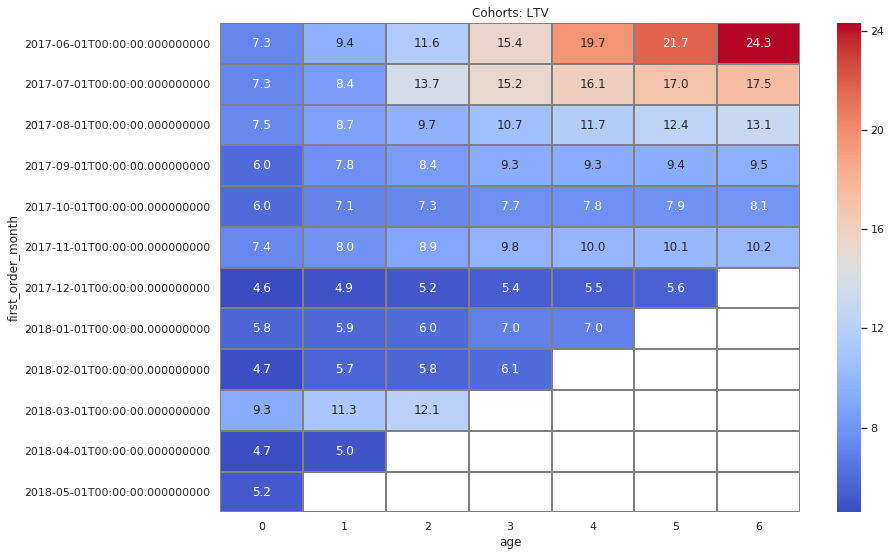

age
0     6.314485
1     7.461027
2     8.872668
3     9.631347
4    10.885888
5    12.011587
6    13.764442
dtype: float64


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,7.256316,2.18411,2.20753,3.75916,4.26947,2.04916,2.58147
2017-07-01,7.291875,1.09569,5.35463,1.507,0.878313,0.899875,0.446875
2017-08-01,7.493363,1.19726,1.01027,0.964779,1.03929,0.666372,0.680177
2017-09-01,6.014714,1.80181,0.559295,0.924846,0.0387665,0.0953304,0.084978
2017-10-01,6.018618,1.05582,0.244765,0.387824,0.0632647,0.108206,0.183324
2017-11-01,7.390895,0.573796,0.96358,0.89392,0.163272,0.105957,0.0807099
2017-12-01,4.584290,0.311027,0.288761,0.24571,0.0265861,0.0956193,
2018-01-01,5.768824,0.0905042,0.144538,0.973361,0.0492857,,
2018-02-01,4.686545,0.999855,0.0673455,0.369527,,,


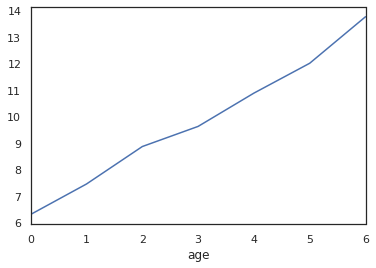

In [87]:
Ltv(purchases[purchases['source_id'] == 1])

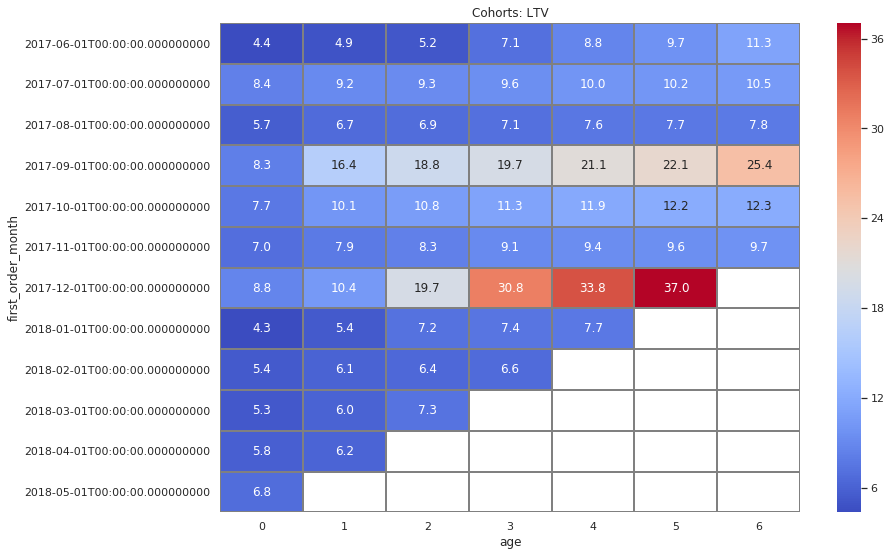

age
0     6.501886
1     8.124888
2     9.974403
3    12.088853
4    13.802794
5    15.491555
6    12.831257
dtype: float64


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.441191,0.49166,0.271915,1.92489,1.66681,0.918979,1.60221
2017-07-01,8.429663,0.765577,0.0593269,0.321779,0.432163,0.18625,0.298846
2017-08-01,5.738862,0.935935,0.178293,0.250894,0.515122,0.0630894,0.121707
2017-09-01,8.282217,8.12846,2.36244,0.923122,1.40819,0.974932,3.31783
2017-10-01,7.676364,2.45588,0.660758,0.54,0.556288,0.266364,0.0996717
2017-11-01,6.989347,0.908543,0.437613,0.783568,0.313166,0.143191,0.144422
2017-12-01,8.808976,1.54244,9.33105,11.1003,3.04517,3.21008,
2018-01-01,4.343322,1.09007,1.73723,0.244726,0.329007,,
2018-02-01,5.417031,0.647406,0.323174,0.255631,,,


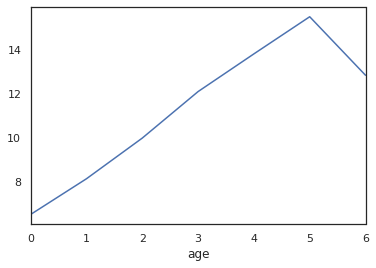

In [88]:
Ltv(purchases[purchases['source_id'] == 2])

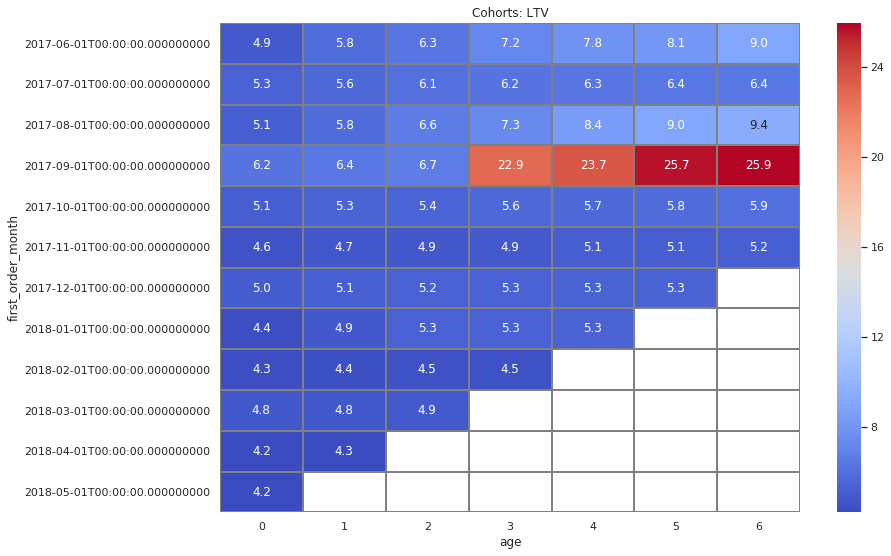

age
0     4.834917
1     5.203086
2     5.584781
3     7.680864
4     8.445984
5     9.345449
6    10.325525
dtype: float64


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.945026,0.902943,0.449297,0.872734,0.663307,0.297734,0.905339
2017-07-01,5.286548,0.319527,0.454752,0.153286,0.096974,0.107872,0.0264303
2017-08-01,5.050139,0.752222,0.831778,0.710333,1.07969,0.594639,0.385111
2017-09-01,6.196469,0.182462,0.33146,16.1679,0.77275,2.01844,0.28017
2017-10-01,5.091069,0.223048,0.12037,0.122095,0.113365,0.0975132,0.143989
2017-11-01,4.560390,0.187244,0.117763,0.055469,0.137056,0.0399567,0.108456
2017-12-01,5.006952,0.135331,0.0899481,0.054773,0.0194682,0.00801556,
2018-01-01,4.351754,0.518341,0.384566,0.031643,0.0275987,,
2018-02-01,4.321726,0.0923009,0.0462242,0.00986726,,,


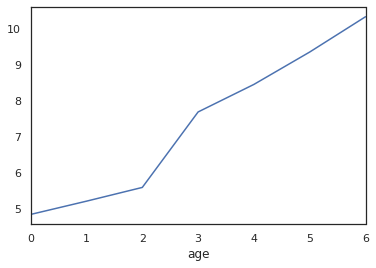

In [89]:
Ltv(purchases[purchases['source_id'] == 5])

LTV — «пожизненная» ценность клиента — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. 
Жизненный цикл пользователя составляет 6 месяцев. За этот период пользователь приносит 8.4. Самый высокий накопительный показатель ltv в четвретой когорте, он заметно отличается от других когорт и влияет на среднее. Во всех когортах, кроме 1-ой и 4-ой накопительный ltv ниже 8-ми.

Относительно устройств накопительный ltv через полгода на десктопных утройствах 8.8, тогда как на сенсорных всего 6.5. Хотя начальный ltv на обоих устройствах примерно одинаков. 

Относительно источников заметно выделяются источники 1, 2 и 5. Накопительный ltv среди них в пределах 10-14. При этом с источника 1 больше всего денег принесла 1-ая и 2-ая когорты, с источника 2 - 4-ая и 7-ая когорты, с источника 5 - 4-ая когорта.

### 2.3. Маркетинг

In [90]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [91]:
costs['costs'].sum()

329131.62

In [92]:
source_cost = costs.groupby('source_id')['costs'].sum()

In [93]:
source_cost

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

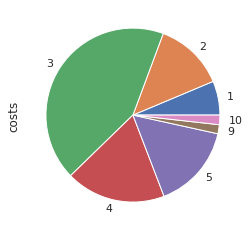

In [94]:
source_cost.plot(kind='pie')

In [95]:
source_cost = source_cost.reset_index()

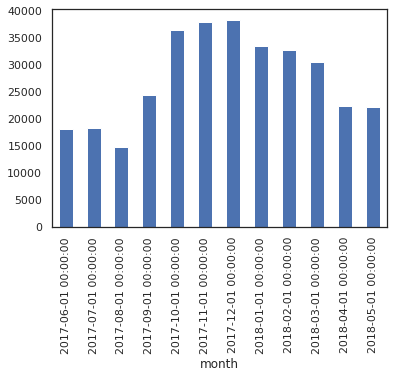

In [96]:
costs.groupby('month')['costs'].sum().plot.bar()

In [97]:
costs.groupby('month')['costs'].sum().mean()

27427.634999999995

In [98]:
#Сколько стоило привлечение одного покупателя из каждого источника?
source_visits = purchases.groupby('source_id', as_index=False).agg({'revenue': 'sum', 'uid': 'count'})

In [99]:
source_visits

,source_id,revenue,uid
0,1,27821.17,4833
1,2,45041.88,6132
2,3,53913.18,13119
3,4,55109.65,12743
4,5,51066.02,9121
5,7,1.22,1
6,9,5498.83,1598
7,10,4427.31,1550


In [100]:
source = source_visits.merge(source_cost, on = 'source_id', how='left')

In [101]:
source

,source_id,revenue,uid,costs
0,1,27821.17,4833,20833.27
1,2,45041.88,6132,42806.04
2,3,53913.18,13119,141321.63
3,4,55109.65,12743,61073.60
4,5,51066.02,9121,51757.10
5,7,1.22,1,NaN
6,9,5498.83,1598,5517.49
7,10,4427.31,1550,5822.49


In [102]:
source.columns = ['source_id', 'revenue', 'n_users', 'costs']

In [103]:
source['cac'] = source['costs'] / source['n_users']

In [104]:
#источник 7 не будем учитывать,т.к. оттуда пришел только 1 пользователь  и затрат не было
source = source[source['source_id'] != 7]

In [105]:
source['ltv'] = source['revenue']/source['n_users']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
source['roi'] = (source['ltv']- source['cac'])/source['cac']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
source

,source_id,revenue,n_users,costs,cac,ltv,roi
0,1,27821.17,4833,20833.27,4.310629,5.756501,0.335420
1,2,45041.88,6132,42806.04,6.980763,7.345382,0.052232
2,3,53913.18,13119,141321.63,10.772287,4.109550,-0.618507
3,4,55109.65,12743,61073.60,4.792718,4.324700,-0.097652
4,5,51066.02,9121,51757.10,5.674498,5.598730,-0.013352
6,9,5498.83,1598,5517.49,3.452747,3.441070,-0.003382
7,10,4427.31,1550,5822.49,3.756445,2.856329,-0.239619


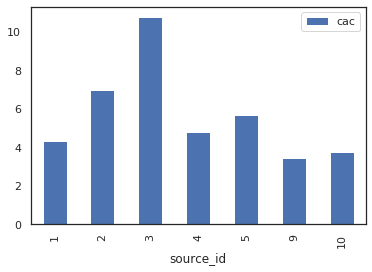

In [108]:
source.plot(kind='bar', x='source_id', y='cac')

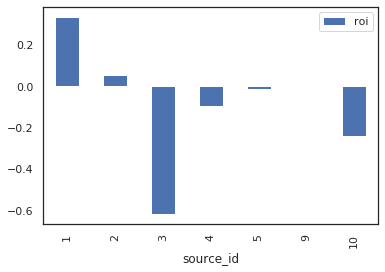

In [109]:
source.plot(kind='bar', x='source_id', y='roi')

Вывод:

- Сколько денег потратили? Всего / на каждый источник / по времени  
Всего потратили 329 тыс. Самые высокие затраты были с октября по март. Самая высокая посещаемость отмечалась в этот  же период. В среднем в месяц на привлечение тратилось 27.5 тыс.
Максимальные затраты на привлечение были в 3-м источнике, они составили 140 тыс в год. Минимальные - в источнике 9 и 10, по 5 тыс в год. 
- Сколько стоило привлечение одного покупателя из каждого источника?   
Привлечение 1 покупателя варьируется от 3.5 (источники 9 и 10) до 10.7 (источник 3). 
- На сколько окупились расходы? (ROI)  
Расходы окупились только в источнике 1 и 2. При этом в источнике 1 самый высокий показатель, roi=33%, в источнике 2 roi=5%. Для всех остальных источников показатель отрицательный. Самый неэффективный источник - 3. Показатель roi=-62%. Т.е затраты на привлечение на 62% превысили прибыль.

<div id='id-section3'/>

## 3. Вывод

Половина пользователей пользуются сервисом до 5 минут, продолжительность сессии большей части из них составляет 1 минуту. При этом на сенсорных устройствах продолжительность сессии короче, чем на десктопных, в 2 раза.
Продолжительность сессии на сенсорных устройствах у 50% пользователей - 3 минуты.
Продолжительность сессии на десктопных устройствах у 50% пользователей - 6 минут.
Пользователей, просматривающих сайт с десктопных устройств, в 2.7 раза больше, чем с сенсорных.
Поэтому в первую очередь необходимо развивать сайт для десктопных устройств. 

Есть еще визиты с нулевой продолжительность, которые составляют 10% от общего числа. Это довольно много.
Визиты с нулевой продолжительность не зависят от типа устройства. Рекомендую обратить внимание на таких пользователей, подумать над причинами и возможностью перевести таких пользователей в активных.

В основном в день сайтом пользуются от 500 до 1500 человек. Среднее значение: 900. Число сессий незначительно больше. То есть на 1 человека приходится 1 сессия в день.  
Средняя посещяемость сайта в месяц - 23тыс уникальных пользователей. Среднее число сессий в месяц - 30 тыс. Большинство посетителей не заходят на сайт чаще 1 раз в месяц. Количество сессий на одного человека в месяц: 1.28. 
С октября по март наблюдается рост числа пользователей, максимальное количество пользователей наблюдалось в ноябре. С апреля начинается спад. Причина: в этот период были более высокие затраты на привлечение клиентов.

Время жизни пользователей - полгода. Т.е. это пользователи , которые только 1 раз были на сайте, либо зашли повторно в течение полугода. Большинство пользователей пользовались сайтом только 1 раз. 

Коэффициент удержания низкий. Через месяц в среднем возвращается всего 6.5% пользователей. Это самый высокий retention rate за весь период. С каждым месяцем коэффициент падает. Наиболее высокие показатели у 1-ой когорты. Там даже в конце года RR=4%, в других когортах показатели ниже.
В апреле и мае RR очень низкий по всем когортам. И в большинстве когорт составляет 2%.

Рекомендую провести дополнительный анализ и выяснить, почему пользователи не пользуются повторно сервисом. Возможно, возникли трудности в первом случае или был другой негативный опыт. Можно посмотреть, были ли обращения в службу клиентского сервиса. Либо узнать у самих пользоваталей с помощью опроса.

Retention rate пользователей, использующих десктопные устройства , выше чем у пользователей, использующих сенсорные. Разница незначительная, в пределах 1-го процента.

По источникам же показатели значительно различаются. Самый высокий RR у источников 1, 2 и 9. Через месяц в среднем возвращается 14-17% пользователей. Показатели в последующих месяцах выше средних по всем когортам.

Как правило, пользователи покупают в день первого визита на сайт. Можно предположить, что сервис вызывает доверие.  
Средний чек равен 5.0. Обусловлено эта цифра выбросами. По медиане чек в два раза меньше и составляет 2.5. Есть незначительное число покупок с суммой чека, равной 0. Возможно, это какие-то акции или подарки.  

LTV — «пожизненная» ценность клиента — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок.  За жизненный цикл (полгода) пользователь приносит 8.4.

Относительно устройств накопительный ltv через полгода на десктопных утройствах 8.8, тогда как на сенсорных всего 6.5. Хотя начальный ltv на обоих устройствах примерно одинаков. 

Относительно источников заметно выделяются источники 1, 2 и 5. Накопительный ltv среди них в пределах 10-14. При этом с источника 1 больше всего денег принесла 1-ая и 2-ая когорты, с источника 2 - 4-ая и 7-ая когорты, с источника 5 - 4-ая когорта.

Максимальные затраты на привлечение были в 3 источнике. Он же оказался самым дорогим в разрезе стоимости привлечения 1 клиента. И самым неэффективным. Затраты на привлечение на 62% превысили прибыль. 
Расходы окупились только в источнике 1 и 2. При этом в источнике 1 самый высокий показатель, roi=33%, в источнике 2 roi=5%. 
Рекомендую в дальнейшем использовать эти источники для привлечения. У источника 2 самый высокий ltv, подумать, можно ли снизить затраты на привлечение в этом источнике.  
Еще рекомендую обратить внимание на источник 9. Там высокий retention rate, низкая стоимость привлечения, roi равен 0. То есть пользователи пользуются сайтом, но неохотно покупают. Если получится повысить количество или средний чек покупок, то такой источник тоже стоит использовать.